# RL solutions for combinatorial games: Monte Carlo Control

## The Game of Nim(Mathematical jargon):
- The Game of Nim is a simple 2 player impartial perfect information game
- Any Combinatorial Game is equivalent to a one heap game of nim under normal play $\rightarrow$ [Sprague Grundy Theorem](https://en.wikipedia.org/wiki/Sprague%E2%80%93Grundy_theorem)
- refer [MIT lecture notes](https://web.mit.edu/sp.268/www/nim.pdf) or [wikipedia](https://en.wikipedia.org/wiki/Nim) for more

## The Game of Nim(In simpler terms):
- The game of Nim is given by the following setting:
- There is a set of **heaps** arranged in front of you each containing some number of **pebbles**
- On your turn you must pick a non-empty heap and take out any non-zero number of pebbles from it and obviously you cannot take out more pebbles than there are in the heap
- There are 2 ways to play Nim which are "equivalent"(quotes here because the notation of equivalence here is clearly defined but omitted here)
    1. Normal Play: The player who empties the last heap wins
    2. Misère Play: The player who is forced to take the last pebble wins

### The winning strategy:
- It can be proved that this game has a winning strategy which is to always end your turn on a **Nim Sum** of zero
- For the case of our simple nim game, the nim sum is simply the XOR of the number of pebbles in each heap

Note: Under certain conditions, **Go** endgames can be modeled as a combinatorial game

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

### Defining the Game Simulator
`SimpleNim` is a class that allows the agent to interact with the game and perform actions via SimpleNim::make_move()

In [3]:
# A Simple Nim Game
class SimpleNim:
    def __init__(self, state):
        self.heaps = state
        self.turn = 0
        self.num_heaps = len(self.heaps)

    def get_state(self):
        if isinstance(self.heaps, list):
            return tuple(self.heaps)
        else:
            return tuple(self.heaps.tolist())

    def get_num_heaps(self):
        return self.num_heaps

    def get_heap_size(self, heap_index):
        if 0 <= heap_index < self.num_heaps:
            return self.heaps[heap_index]
        return None

    def is_game_over(self):
        return all(pebbles == 0 for pebbles in self.heaps)

    def make_move(self, heap_index, num_pebbles):
        if self.is_game_over():
            return False

        # Validate the move
        if 0 <= heap_index < self.num_heaps and 0 < num_pebbles <= self.heaps[heap_index]:
            self.heaps[heap_index] -= num_pebbles
            self.turn = 1 - self.turn  # Switch turns
            return True
        return False

    def winner(self):
        if self.is_game_over():
            return 1 - self.turn
        return None

### Optimal Play
- There exists an optimal strategy on positions having nim sum of 0
- Here we define an opponent who plays optimally on positions of nim sum 0 and makes a move that removes the least possible number of pebbles(one pebble) hoping for the agent to fumble on their turn and give the opponent a state with nim sum zero

In [4]:
def nim_sum(s):
    xor = 0
    for heap in s:
        xor ^= heap
    return xor

In [5]:
# Function to play the optimal move in Nim, end on a zero nim-sum
def play_optimal(game):
    if game.is_game_over():
        return None

    nim_sum_value = nim_sum(game.get_state())
    heaps = game.get_state()
    for i in range(game.get_num_heaps()):
        if heaps[i] > 0 and (nim_sum_value ^ heaps[i]) < heaps[i]:
            # Make the move that results in a zero nim-sum
            game.make_move(i, heaps[i] - (nim_sum_value ^ heaps[i]))
            return True
    # If no optimal move is found
    index = np.random.randint(0, game.get_num_heaps())
    while game.get_heap_size(index) == 0:
        index = np.random.randint(0, game.get_num_heaps())
    game.make_move(index, 1)

In [6]:
def play_random(game):
    if game.is_game_over():
        return
    heaps = game.get_state()

    index = np.random.randint(0, len(heaps))
    while heaps[index] == 0:
        index = np.random.randint(0, len(heaps))
    return (index, np.random.randint(1, heaps[index]+1))

In [7]:
# opponent that plays optimal with probability prob_optimal
def play_optimal_random(game, prob_optimal=1.0):
    random_choice = np.random.rand()
    if random_choice < prob_optimal:
        play_optimal(game)
    else:
        play_random(game)

In [8]:
# simple simulation of a nim game with both players using the optimal strategy
heaps = [10] * 3
game = SimpleNim(heaps)
while not game.is_game_over():
    play_optimal(game)
    print(game.get_state())
print("The winner is Player ", game.winner())

(0, 10, 10)
(0, 10, 9)
(0, 9, 9)
(0, 9, 8)
(0, 8, 8)
(0, 8, 7)
(0, 7, 7)
(0, 7, 6)
(0, 6, 6)
(0, 5, 6)
(0, 5, 5)
(0, 5, 4)
(0, 4, 4)
(0, 4, 3)
(0, 3, 3)
(0, 3, 2)
(0, 2, 2)
(0, 2, 1)
(0, 1, 1)
(0, 1, 0)
(0, 0, 0)
The winner is Player  0


## Defining State and Action Spaces:
**The State** is given by a configuration of heaps($\N_0$ means the set of naturals that includes zero):
$$ \mathcal S = \N_0^h $$
where h is the number of heaps
**Actions** are given by two tuples of heap number and number of pebbles to be taken out:
$$ \mathcal A(s) = H(s) \times \N $$ 
where $\N$ does not include zero and $H(s)$ is the set of heaps having non zero number of pebbles in the state s

### Parameters to tweak:
- **For smaller game sizes**, MC methods converge to the optimum very quickly
- **For larger game sizes**, MC methods converge to a local optimum and get stuck

In [9]:
# for simplicity consider the version of the problem that starts off with same number of pebbles in each heap
num_heaps = 3
initial_pebbles = 10
max_episodes = 1000000
start_state = (initial_pebbles,) * num_heaps

### Epsilon Greedy Policy:
- A policy that chooses to either make an exploratory action or to pick an action via a greedy approach on the current value function
- This policy helps to continue exploring different actions throughout the run
- Here a method update() is provided to update epsilon in order to implement **GLIE**(Greedy in the Limit with Infinite Exploration)
- refer [David Silver's Slides](https://davidstarsilver.wordpress.com/wp-content/uploads/2025/04/lecture-5-model-free-control-.pdf) for a better explanation on GLIE and epsilon greedy policies

In [10]:
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if s not in Q or np.random.random() < self.epsilon:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            num_pebbles = np.random.randint(1, s[index] + 1)
            return (index, num_pebbles)
        else:
            return max(Q[s], key=Q[s].get)

    def final_policy(self, s, Q):
        if s not in Q:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [11]:
class SimpleGreedyPolicy:
    def update(self, epsilon): pass

    def policy(self, s, Q):
        if s not in Q:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        return max(Q[s], key=Q[s].get)

    def final_policy(self, s, Q):
        if s not in Q:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [12]:
def simulate_agent_move(game, states, actions, policy, Q):
    if game.is_game_over():
        return

    curr_state = game.get_state()
    states.append(curr_state)
    curr_action = policy.policy(curr_state, Q)
    actions.append(curr_action)
    game.make_move(curr_action[0], curr_action[1])

    return curr_state, curr_action

#### The red dashed line on the plot indicates the true value of the state

In [13]:
def plot_start_state_returns(Q_start_state_history):
    plt.plot(Q_start_state_history)
    plt.hlines(1.0, 0, len(Q_start_state_history), colors='r', linestyles='dashed')
    plt.xlabel('Episodes')
    plt.ylabel('Return from Start State')
    plt.title('Return from Start State Over Episodes')
    plt.show()

#### Rewards Model
$$R_T = \begin{cases} 
            1 & agent & win \\
            0 & agent & loss
        \end{cases}$$
$$R_t = 0 \hspace{3mm}\forall t<T$$

In [14]:
def generate_episode(policy, s0, Q, negative_on_loss=False, move_opponent=play_optimal_random, a0=None, prob_optimal=1.0):

    # init
    game = SimpleNim(s0)
    states = []
    actions = []
    rewards = []

    first_state = tuple(s0.tolist())

    states.append(first_state)
    if a0 is None: a0 = policy.policy(first_state, Q)

    actions.append(a0)
    game.make_move(a0[0], a0[1])
    # if not game.is_game_over():
    #     rewards.append(0)

    # loop until end of episode
    while not game.is_game_over():
        # opponent move
        move_opponent(game, prob_optimal=prob_optimal)

        if not game.is_game_over():
            rewards.append(0)

        # agent move
        simulate_agent_move(game, states, actions, policy, Q)

    if game.winner() == 0:
        rewards.append(1)
    else:
        if negative_on_loss: rewards.append(-1)
        else: rewards.append(0)
    return states, actions, rewards

In [15]:
def is_optimal(s, a):
    if a[1] == 0: return False
    s = list(s)
    s[a[0]] -= a[1]
    return nim_sum(s) == 0

In [16]:
# Monte Carlo Control with exploring starts
def monte_carlo(gamma=1, policy=EpsilonGreedyPolicy(), negative_on_loss=False, move_opponent=play_optimal_random, exploring_starts=True, every_visit=False, prob_optimal=1.0):
    Q = {} # take default to be zero
    N = {}

    Q_start_state_history = []

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            s0 = np.random.randint(0, initial_pebbles+1, num_heaps)
            while all(s0 == 0):
                s0 = np.random.randint(0, initial_pebbles+1, num_heaps)
            heap_index = np.random.randint(0, num_heaps)
            while s0[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            a0 = (heap_index, np.random.randint(1, s0[heap_index]+1))
        else:
            s0 = np.array([initial_pebbles] * num_heaps, dtype=int)
            a0 = None

        S, A, R = generate_episode(policy=policy, s0=s0, Q=Q, negative_on_loss=negative_on_loss, move_opponent=move_opponent, a0=a0, prob_optimal=prob_optimal)

        if len(S) == 0:
            continue
        visited_at = {}
        for t in range(len(S)):
            if (S[t], A[t]) not in visited_at:
                visited_at[(S[t], A[t])] = t

        G = 0
        for t in range(len(R)-1, -1, -1):
            G = gamma * G + R[t]
            if every_visit or visited_at[(S[t], A[t])] == t:

                if (S[t], A[t]) not in N:
                    N[(S[t], A[t])] = 0
                N[(S[t], A[t])] += 1

                if S[t] not in Q:
                    Q[S[t]] = {}
                if A[t] not in Q[S[t]]:
                    Q[S[t]][A[t]] = 0.0
                Q[S[t]][A[t]] = Q[S[t]][A[t]] + float((G-Q[S[t]][A[t]]))/float(N[(S[t], A[t])])


        policy.update(epsilon=1.0/float(i+1))
        if start_state in Q and len(Q[start_state]) > 0:
            Q_start_state_history.append(max(Q[start_state].values()))
        else:
            Q_start_state_history.append(0)

    return policy, Q, Q_start_state_history

## How Good is our Policy?
- For this game there is a nice way to deal with thinking about how good our policy is in a way that is intuitive
- Rather than looking at cumulative reward functions(value functions) and trying to figure out what they actually mean, we can compare the policy to the optimal strategy which we know:
    - If the current turn ends on a nim sum of zero, the opponent cannot win if the agent continues to follow the optimal strategy from the next turn onwards(end every turn on a nim sum of zero)
    - If not, an opponent playing optimally will always win

### Fumbles:
- Here what I mean by a fumble is: 
    - given a state where on playing optimally the agent can win,
    - the agent chooses an action such that an opponent playing optimally always wins

So, the percentage of winning positions for the agent fumbled is a way to see how good our policy is

In [17]:
import itertools
# evaluate the policy based on number of fumbles
def evaluate_on_winning_positions(policy, Q):
    fumbles = 0
    num_winning_pos = 0
    for s in itertools.product(range(initial_pebbles), repeat=num_heaps):
        if s == (0)*num_heaps: continue
        action = policy.final_policy(s, Q)
        if nim_sum(s) == 0: continue
        if not is_optimal(s, action):
            fumbles+=1
        num_winning_pos+=1
    return fumbles, num_winning_pos

In [18]:
def evaluate_using_fumbles(policy, Q):
    fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
    print('number of fumbles:', fumbles)
    print('total number of winning positions:', num_winning_pos)
    print('percentage of winning positions fumbled: {:.2f} %'.format(fumbles/num_winning_pos*100))

100%|██████████| 1000000/1000000 [00:35<00:00, 28378.01it/s]


{(1, 1): 0.0, (0, 4): 0.0, (0, 3): 0.0, (0, 8): 0.0, (2, 2): 0.0, (2, 8): 0.0, (0, 10): 0.7142857142857142, (0, 2): 0.0, (2, 3): 0.0, (2, 1): 0.0, (0, 9): 0.0, (2, 9): 0.0, (1, 2): 0.0, (2, 4): 0.0, (0, 7): 0.0, (1, 3): 0.0, (2, 10): 0.8275862068965518, (1, 4): 0.0, (2, 7): 0.0, (1, 10): 0.7307692307692308, (1, 5): 0.0, (1, 9): 0.0, (0, 5): 0.0, (0, 1): 0.0, (1, 6): 0.0, (1, 8): 0.0, (2, 5): 0.0, (0, 6): 0.0, (1, 7): 0.0, (2, 6): 0.0}
number of fumbles: 0
total number of winning positions: 924
percentage of winning positions fumbled: 0.00 %


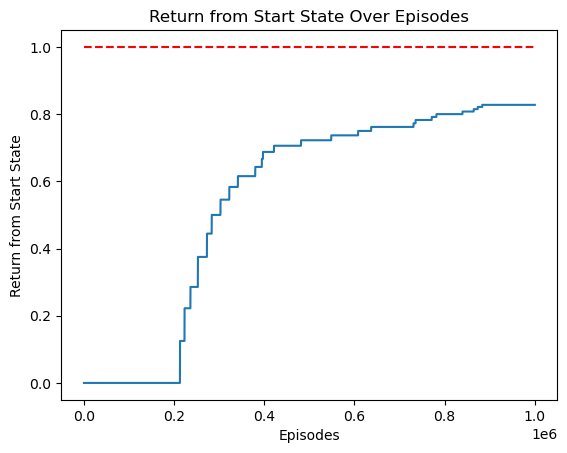

In [19]:
# Epsilon Greedy and exploring starts
policy, Q, history = monte_carlo(policy=EpsilonGreedyPolicy(), exploring_starts=True)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history)

100%|██████████| 1000000/1000000 [00:36<00:00, 27601.67it/s]


{(2, 5): 0.0, (1, 5): 0.0, (2, 7): 0.0, (1, 2): 0.0, (0, 6): 0.0, (0, 2): 0.0, (2, 3): 0.0, (0, 9): 0.0, (1, 6): 0.0, (0, 4): 0.0, (1, 4): 0.0, (0, 5): 0.0, (0, 8): 0.0, (2, 10): 0.8, (2, 4): 0.0, (1, 10): 0.8799999999999999, (2, 9): 0.0, (1, 7): 0.0, (1, 3): 0.0, (0, 10): 0.8499999999999999, (0, 7): 0.0, (1, 8): 0.0, (0, 3): 0.0, (1, 1): 0.0, (2, 6): 0.0, (2, 8): 0.0, (1, 9): 0.0, (2, 1): 0.0, (0, 1): 0.0, (2, 2): 0.0}
number of fumbles: 0
total number of winning positions: 924
percentage of winning positions fumbled: 0.00 %


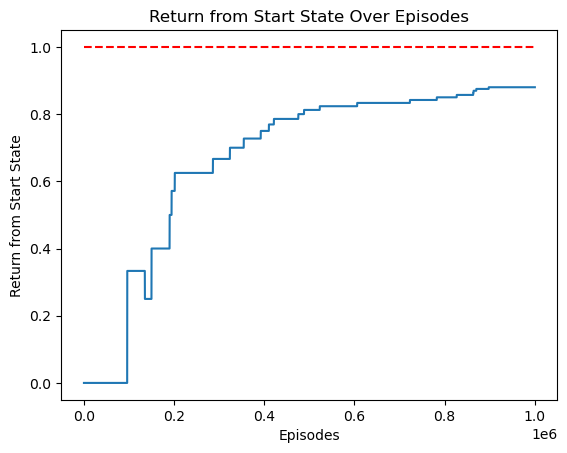

In [20]:
policy, Q, history = monte_carlo(policy=EpsilonGreedyPolicy(), exploring_starts=True, every_visit=True)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history)

100%|██████████| 1000000/1000000 [00:41<00:00, 24084.73it/s]


{(1, 9): 0.0, (0, 10): 0.7567567567567566, (1, 3): 0.0, (1, 6): 0.0, (1, 2): 0.0, (2, 6): 0.0, (2, 2): 0.0, (2, 9): 0.0, (2, 3): 0.0, (0, 7): 0.0, (1, 1): 0.0, (0, 5): 0.0, (0, 1): 0.0, (1, 7): 0.0, (1, 4): 0.0, (1, 10): 0.8888888888888887, (0, 8): 0.0, (0, 2): 0.0, (0, 6): 0.0, (0, 4): 0.0, (2, 1): 0.0, (0, 3): 0.0, (2, 10): 0.9249999999999997, (1, 8): 0.0, (2, 8): 0.0, (0, 9): 0.0, (2, 7): 0.0, (2, 4): 0.0, (1, 5): 0.0, (2, 5): 0.0}
number of fumbles: 0
total number of winning positions: 924
percentage of winning positions fumbled: 0.00 %


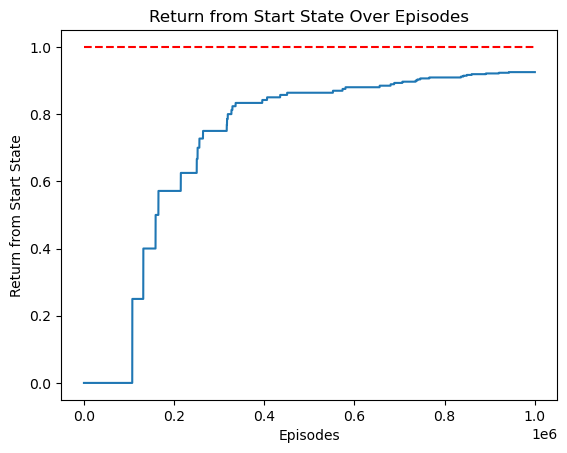

In [21]:
# Simple Greedy Policy and exploring starts
policy, Q, history = monte_carlo(policy=SimpleGreedyPolicy(), exploring_starts=True)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history)

### Negative reward on losing
- Something to notice here is that due to the low win rate of the agent against an optimal opponent, there are very few samples with a non-zero reward(which prompts improvement)
- this may slow down the learning process
- So, what if we use a negative reward for a loss to force improvement?

#### Changes to rewards model
$$R_T = \begin{cases} 
            1 & agent & win \\
            -1 & agent & loss
        \end{cases}$$
$$R_t = 0 \hspace{3mm}\forall t<T$$

100%|██████████| 1000000/1000000 [00:35<00:00, 28439.09it/s]


{(1, 3): -1.0, (2, 1): -1.0, (1, 1): -1.0, (0, 1): -1.0, (0, 7): -1.0, (1, 2): -1.0, (2, 6): -1.0, (2, 7): -1.0, (1, 10): 0.8333333333333333, (2, 2): -1.0, (1, 6): -1.0, (0, 6): -1.0, (0, 3): -1.0, (2, 4): -1.0, (0, 5): -1.0, (2, 10): 0.5714285714285714, (0, 9): -1.0, (2, 9): -1.0, (0, 2): -1.0, (0, 10): 0.7391304347826088, (0, 8): -1.0, (2, 8): -1.0, (1, 5): -1.0, (2, 5): -1.0, (1, 9): -1.0, (0, 4): -1.0, (1, 7): -1.0, (2, 3): -1.0, (1, 4): -1.0, (1, 8): -1.0}
number of fumbles: 0
total number of winning positions: 924
percentage of winning positions fumbled: 0.00 %


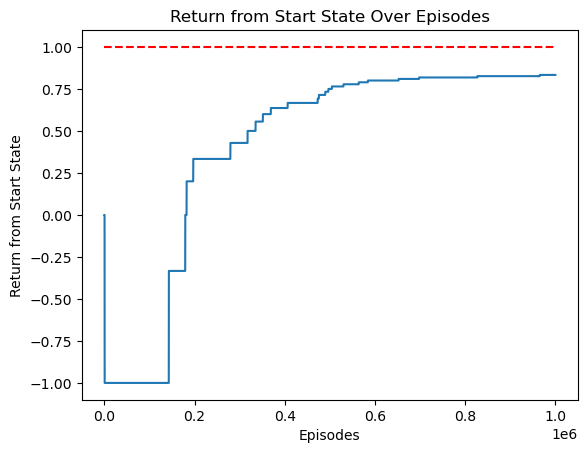

In [22]:
# Epsilon Greedy and exploring starts first visit with negative rewards
policy, Q, history_on_policy_first_visit = monte_carlo(negative_on_loss=True, policy=EpsilonGreedyPolicy(), exploring_starts=True)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history_on_policy_first_visit)

100%|██████████| 1000000/1000000 [00:33<00:00, 29441.57it/s]


{(1, 8): -1.0, (2, 4): -1.0, (2, 3): -1.0, (1, 2): -1.0, (0, 7): -1.0, (1, 9): -1.0, (2, 7): -1.0, (1, 4): -1.0, (1, 10): 0.6666666666666667, (1, 6): -1.0, (2, 5): -1.0, (0, 3): -1.0, (1, 7): -1.0, (0, 2): -1.0, (1, 1): -1.0, (1, 3): -1.0, (2, 9): -1.0, (1, 5): -1.0, (0, 6): -1.0, (0, 8): -1.0, (0, 10): 0.8787878787878788, (0, 1): -1.0, (0, 4): -1.0, (2, 6): -1.0, (2, 10): 0.6799999999999998, (0, 5): -1.0, (2, 1): -1.0, (2, 8): -1.0, (0, 9): -1.0, (2, 2): -1.0}
number of fumbles: 0
total number of winning positions: 924
percentage of winning positions fumbled: 0.00 %


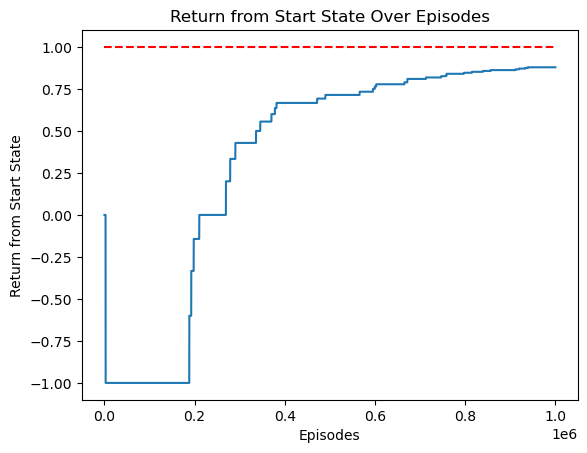

In [23]:
policy, Q, history_on_policy_every_visit = monte_carlo(negative_on_loss=True, policy=EpsilonGreedyPolicy(), exploring_starts=True, every_visit=True)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history_on_policy_every_visit)

100%|██████████| 1000000/1000000 [00:42<00:00, 23592.93it/s]


{(0, 1): -1.0, (1, 7): -1.0, (1, 2): -1.0, (2, 2): -1.0, (2, 10): 0.7333333333333333, (1, 6): -1.0, (2, 9): -1.0, (1, 1): -1.0, (0, 5): -1.0, (2, 7): -1.0, (1, 3): -1.0, (1, 5): -1.0, (0, 7): -1.0, (2, 6): -1.0, (0, 4): -1.0, (0, 6): -1.0, (0, 3): -1.0, (2, 1): -1.0, (1, 4): -1.0, (2, 3): -1.0, (1, 8): -1.0, (2, 4): -1.0, (0, 2): -1.0, (0, 8): -1.0, (0, 9): -1.0, (1, 9): -1.0, (2, 8): -1.0, (1, 10): 1.0, (2, 5): -1.0, (0, 10): 1.0}
number of fumbles: 0
total number of winning positions: 924
percentage of winning positions fumbled: 0.00 %


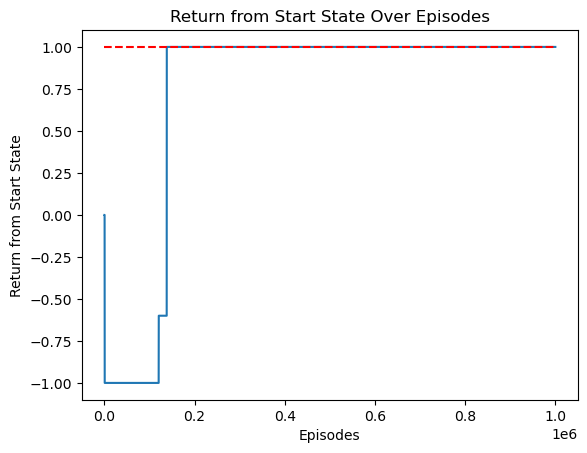

In [24]:
# Simple Greedy Policy and exploring starts first visit with negative rewards
policy, Q, history = monte_carlo(negative_on_loss=True, policy=SimpleGreedyPolicy(), exploring_starts=True)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history)

100%|██████████| 1000000/1000000 [00:45<00:00, 22165.19it/s]


{(0, 8): 0.05263157894736841, (0, 1): 0.40740740740740744, (1, 8): -0.27272727272727276, (2, 5): 0.4666666666666667, (0, 5): 0.5714285714285714, (0, 6): -0.09090909090909091, (2, 8): 0.0909090909090909, (2, 2): 0.2222222222222222, (2, 7): -0.12000000000000001, (2, 10): 0.21428571428571422, (0, 2): 0.3513513513513514, (2, 6): -0.05263157894736841, (2, 4): -0.13333333333333333, (2, 1): 0.09090909090909094, (1, 7): 0.07692307692307693, (1, 1): 0.33333333333333337, (0, 10): 0.17647058823529413, (1, 4): 0.07142857142857142, (1, 10): 0.1851851851851852, (1, 3): -0.12, (0, 4): 0.09999999999999999, (2, 3): -0.35714285714285715, (1, 2): 0.06249999999999997, (0, 7): 0.36363636363636365, (2, 9): 0.21739130434782605, (1, 5): 0.44827586206896547, (1, 6): 0.03703703703703702, (0, 3): 0.12000000000000002, (0, 9): 0.2173913043478261, (1, 9): 0.3043478260869565}
number of fumbles: 850
total number of winning positions: 924
percentage of winning positions fumbled: 91.99 %


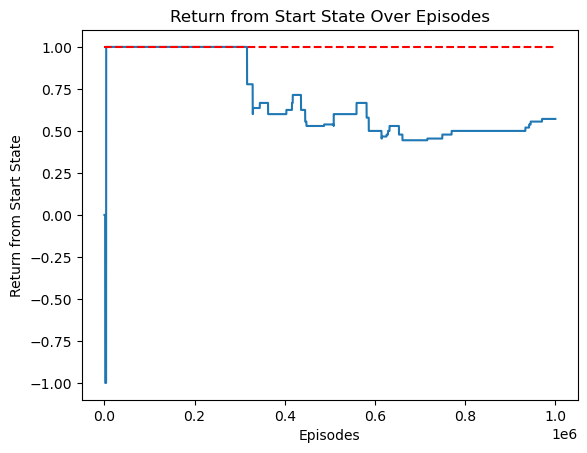

In [25]:
# Suboptimal opponent
policy, Q, history_on_policy_first_visit_suboptimal_opponent = monte_carlo(negative_on_loss=True, policy=EpsilonGreedyPolicy(), exploring_starts=True, move_opponent=play_optimal_random, prob_optimal=0.6)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history_on_policy_first_visit_suboptimal_opponent)

## Off-Policy Monte Carlo Control
- The first method in this notebook is called an on-policy method because the value function being estimated is being used for control.
- But what if we don't have access to a simulator, we might have access to the experience of other agents using different policies
- Further, experience replay [[3](./README.md)] a method that shows good results for Neural Network based RL relies on Off-policy learning. The agent's own past experience is based on a policy that is different from the current one and is used to estimate the value function of the current policy.
- Off-policy methods are those that work off of experience generated by some policy that is independent ("independent" here is not used with any mathematical context) of the agent's policy for control, called the _behaviour_ policy
- This independence can also be leveraged to use an exploratory _behaviour_ policy and a deterministic control policy

- Directly taking sample mean of returns from the sample paths gives the value function with respect to the behaviour policy
- By using a method called [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling) we can obtain the required value function of the control policy
- Here, we use weighted importance sampling, for more refer [[4](README.md)]

In [26]:
# Off-policy Monte Carlo Control using weighted importance sampling with epsilon greedy behavior policy
def monte_carlo_off_policy(gamma=1, negative_on_loss=False, move_opponent=play_optimal, exploring_starts=True, every_visit=False):
    Q = {} # take default to be zero

    behavior_policy = EpsilonGreedyPolicy()
    target_policy = SimpleGreedyPolicy()

    C = {}  # C(s, a) for weighted importance sampling

    Q_start_state_history = []

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            s0 = np.random.randint(0, initial_pebbles+1, num_heaps)
            while all(s0 == 0):
                s0 = np.random.randint(0, initial_pebbles+1, num_heaps)
            heap_index = np.random.randint(0, num_heaps)
            while s0[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            a0 = (heap_index, np.random.randint(1, s0[heap_index]+1))
        else:
            s0 = np.array([initial_pebbles] * num_heaps, dtype=int)
            a0 = None

        S, A, R = generate_episode(policy=policy, s0=s0, Q=Q, negative_on_loss=negative_on_loss, move_opponent=move_opponent, a0=a0)

        if len(S) == 0:
            continue
        visited_at = {}
        for t in range(len(S)):
            if (S[t], A[t]) not in visited_at:
                visited_at[(S[t], A[t])] = t

        G = 0
        W = 1.0
        for t in range(len(R)-1, -1, -1):
            G = gamma * G + R[t]
            if every_visit or visited_at[(S[t], A[t])] == t:

                if (S[t], A[t]) not in C:
                    C[(S[t], A[t])] = 0.0
                C[(S[t], A[t])] += W

                if S[t] not in Q:
                    Q[S[t]] = {}
                if A[t] not in Q[S[t]]:
                    Q[S[t]][A[t]] = 0.0
                Q[S[t]][A[t]] += W*float(G-Q[S[t]][A[t]])/float(C[(S[t], A[t])])

                if A(t) != target_policy.final_policy(S[t], Q):
                    W = 0.0
                    break
                W = W * (1.0 / behavior_policy.epsilon)


        policy.update(epsilon=1.0/float(i+1))
        if start_state in Q and len(Q[start_state]) > 0:
            Q_start_state_history.append(max(Q[start_state].values()))
        else:
            Q_start_state_history.append(0)

    return policy, Q, Q_start_state_history

100%|██████████| 1000000/1000000 [00:36<00:00, 27574.01it/s]


{(2, 8): -1.0, (2, 1): -1.0, (0, 1): -1.0, (2, 2): -1.0, (1, 9): -1.0, (0, 4): -1.0, (0, 7): -1.0, (0, 8): -1.0, (1, 1): -1.0, (1, 6): -1.0, (2, 6): -1.0, (1, 4): -1.0, (2, 5): -1.0, (1, 10): 0.625, (0, 10): 0.6923076923076922, (0, 2): -1.0, (2, 4): -1.0, (2, 9): -1.0, (0, 3): -1.0, (1, 5): -1.0, (1, 7): -1.0, (2, 10): 0.875, (2, 3): -1.0, (0, 6): -1.0, (1, 3): -1.0, (2, 7): -1.0, (0, 9): -1.0, (1, 2): -1.0, (1, 8): -1.0, (0, 5): -1.0}
number of fumbles: 0
total number of winning positions: 924
percentage of winning positions fumbled: 0.00 %


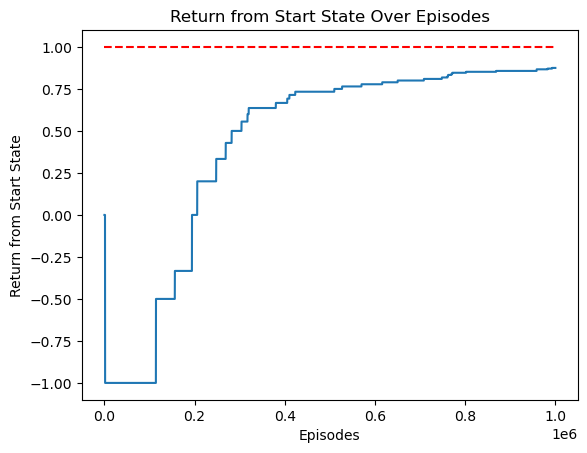

In [27]:
policy, Q, history_off_policy_first_visit = monte_carlo(negative_on_loss=True, exploring_starts=True, every_visit=False)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history_off_policy_first_visit)

100%|██████████| 1000000/1000000 [00:34<00:00, 28656.76it/s]


{(2, 5): -1.0, (1, 3): -1.0, (2, 1): -1.0, (1, 8): -1.0, (2, 3): -1.0, (1, 9): -1.0, (2, 10): 0.7600000000000001, (1, 7): -1.0, (1, 6): -1.0, (0, 7): -1.0, (0, 10): 0.8095238095238094, (0, 4): -1.0, (1, 5): -1.0, (0, 6): -1.0, (0, 3): -1.0, (0, 8): -1.0, (1, 10): 0.7500000000000001, (2, 2): -1.0, (1, 2): -1.0, (2, 4): -1.0, (2, 7): -1.0, (2, 6): -1.0, (0, 2): -1.0, (1, 4): -1.0, (1, 1): -1.0, (0, 5): -1.0, (0, 1): -1.0, (2, 9): -1.0, (0, 9): -1.0, (2, 8): -1.0}
number of fumbles: 0
total number of winning positions: 924
percentage of winning positions fumbled: 0.00 %


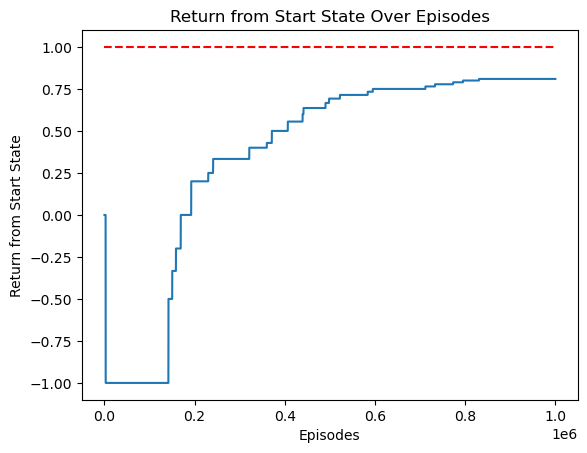

In [28]:
policy, Q, history_off_policy_every_visit = monte_carlo(negative_on_loss=True, exploring_starts=True, every_visit=True)
print(Q[start_state])
evaluate_using_fumbles(policy, Q)
plot_start_state_returns(history_off_policy_every_visit)

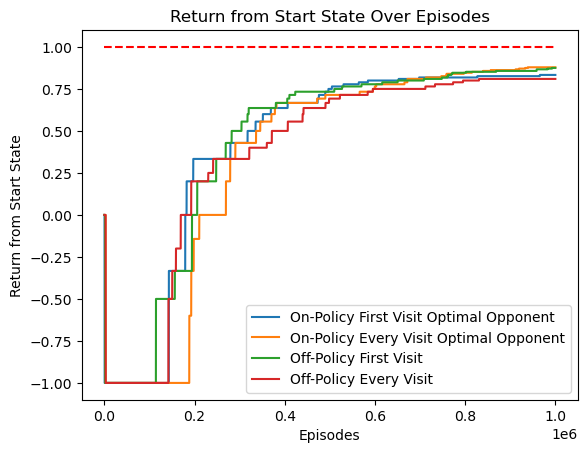

In [30]:
# Compare everything
plt.plot(history_on_policy_first_visit, label='On-Policy First Visit Optimal Opponent')
plt.plot(history_on_policy_every_visit, label='On-Policy Every Visit Optimal Opponent')
plt.plot(history_off_policy_first_visit, label='Off-Policy First Visit')
plt.plot(history_off_policy_every_visit, label='Off-Policy Every Visit')
plt.hlines(1.0, 0, len(history_on_policy_first_visit), colors='r', linestyles='dashed')
plt.xlabel('Episodes')
plt.ylabel('Return from Start State')
plt.title('Return from Start State Over Episodes')
plt.legend()
plt.show()